In [1]:
import sys
import os
import requests
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras_visualizer import visualizer
from IPython.display import display, Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

2025-11-25 15:36:01.783464: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 15:36:01.844141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 15:36:01.845171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 15:36:03.013791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
keras_ann_utility = import_local_or_github('keras_ann_utility', directory='../Utility')
keras_advanced_utility = import_local_or_github('keras_advanced_utility', directory='../Utility')

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Download, load, clean, and add noise to data as in Lesson 12.A

In [3]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)
traj_list = generate_training_data_utility.add_noise_to_trajectory_data(traj_list, 0.02)

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories.zip
Successfully downloaded planar_drone_trajectories.zip (29316396 bytes)
unzipping...
Number of trajectories: 
3001
Number of good trajectories: 
2924


# Build augmented data frames

In [4]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot'] 
control_names = ['j1', 'j2']
output_names = ['sensor_optic_flow', 'sensor_theta', 'sensor_theta_dot', 'sensor_accel_x', 'sensor_accel_z']

In [5]:
state_offsets = [0, -1]
control_offsets = [0, -1]
output_offsets = [0]

In [6]:
traj_augment_list = []
for traj in traj_list:
    traj_augment = keras_ann_utility.collect_offset_rows(traj, states=state_names, controls=control_names, outputs=output_names, 
                        state_offsets=state_offsets, control_offsets=control_offsets, output_offsets=output_offsets)
    
    traj_augment_list.append(traj_augment)

traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

np.round(traj_augment_all, 4)

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,z_offset_-1,z_dot_offset_-1,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1,sensor_optic_flow_offset_0,sensor_theta_offset_0,sensor_theta_dot_offset_0,sensor_accel_x_offset_0,sensor_accel_z_offset_0
0,-0.7909,-0.0235,-9.9942,1.7616,9.6493,-5.1965,-0.4713,-5.6977,-10.1085,1.1355,10.1570,-4.9816,-0.0178,19.5003,2.2642,9.9714,0.1706,-0.7752,0.0041,-49.8649,-2.7803
1,-0.7644,-0.0188,-9.7378,3.1571,9.1938,-4.8081,-0.7909,-0.0235,-9.9942,1.7616,9.6493,-5.1965,-0.0075,27.3603,-0.0178,19.5003,0.3104,-0.7858,0.0117,13.8171,4.0048
2,-0.7715,0.0380,-9.3449,5.0931,8.7717,-3.8231,-0.7644,-0.0188,-9.7378,3.1571,9.1938,-4.8081,0.0104,32.8837,-0.0075,27.3603,0.5857,-0.7762,-0.0189,19.3557,9.5690
3,-0.7704,-0.0141,-8.6896,7.3873,8.4276,-2.5041,-0.7715,0.0380,-9.3449,5.0931,8.7717,-3.8231,-0.0216,35.6688,0.0104,32.8837,0.9369,-0.8261,0.0177,23.2320,13.4190
4,-0.7696,0.0386,-7.8049,9.9213,8.2340,-0.9771,-0.7704,-0.0141,-8.6896,7.3873,8.4276,-2.5041,1.1377,36.0940,-0.0216,35.6688,1.1904,-0.7828,-0.0123,25.2677,15.4429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260231,0.0511,-0.0251,0.6857,0.7169,2.1161,-1.9294,0.0695,0.3227,0.5711,0.8568,2.3448,-2.5317,-0.0570,17.0136,-0.1431,15.7622,0.3567,0.0681,-0.0282,-1.2222,7.1567
260232,0.0913,-0.1099,0.7345,0.5854,1.9567,-1.2100,0.0511,-0.0251,0.6857,0.7169,2.1161,-1.9294,-0.0138,17.6887,-0.0570,17.0136,0.3182,0.0471,-0.1068,-1.1689,7.8431
260233,0.0507,-0.1899,0.7690,0.5136,1.9031,-0.4321,0.0913,-0.1099,0.7345,0.5854,1.9567,-1.2100,-0.0837,17.8136,-0.0138,17.6887,0.2670,0.0427,-0.2328,-0.8576,7.9335
260234,0.0476,-0.4377,0.8616,0.4595,1.9058,0.3819,0.0507,-0.1899,0.7690,0.5136,1.9031,-0.4321,-0.0970,17.3138,-0.0837,17.8136,0.2322,0.0140,-0.4502,-0.2679,7.4879


In [7]:
n_state = len(state_names)
n_control = len(control_names)
n_output = len(output_names)
delay_embedding = len(state_offsets)

print('States:', n_state)
print('Controls:', n_control)
print('Outputs:', n_output)
print('Delay embedding:', delay_embedding)

States: 6
Controls: 2
Outputs: 5
Delay embedding: 2


In [8]:
# Augmented state data
X = traj_augment_all.iloc[:, 0:n_state*delay_embedding]
X

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,z_offset_-1,z_dot_offset_-1
0,-0.790935,-0.023537,-9.994152,1.761554,9.649339,-5.196469,-0.471290,-5.697702,-10.108509,1.135540,10.157020,-4.981575
1,-0.764366,-0.018834,-9.737841,3.157102,9.193778,-4.808143,-0.790935,-0.023537,-9.994152,1.761554,9.649339,-5.196469
2,-0.771451,0.037954,-9.344869,5.093121,8.771740,-3.823124,-0.764366,-0.018834,-9.737841,3.157102,9.193778,-4.808143
3,-0.770379,-0.014122,-8.689601,7.387336,8.427579,-2.504120,-0.771451,0.037954,-9.344869,5.093121,8.771740,-3.823124
4,-0.769638,0.038613,-7.804867,9.921343,8.234037,-0.977097,-0.770379,-0.014122,-8.689601,7.387336,8.427579,-2.504120
...,...,...,...,...,...,...,...,...,...,...,...,...
260231,0.051128,-0.025135,0.685665,0.716892,2.116089,-1.929423,0.069521,0.322663,0.571131,0.856819,2.344751,-2.531695
260232,0.091283,-0.109945,0.734501,0.585424,1.956676,-1.209970,0.051128,-0.025135,0.685665,0.716892,2.116089,-1.929423
260233,0.050732,-0.189938,0.769025,0.513599,1.903064,-0.432079,0.091283,-0.109945,0.734501,0.585424,1.956676,-1.209970
260234,0.047634,-0.437657,0.861569,0.459544,1.905775,0.381861,0.050732,-0.189938,0.769025,0.513599,1.903064,-0.432079


In [9]:
# Augmented control data
U = traj_augment_all.iloc[:, n_state*delay_embedding:n_state*delay_embedding+n_control*delay_embedding]
U

,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1
0,-0.017752,19.500334,2.264153,9.971379
1,-0.007453,27.360305,-0.017752,19.500334
2,0.010416,32.883750,-0.007453,27.360305
3,-0.021645,35.668808,0.010416,32.883750
4,1.137706,36.093993,-0.021645,35.668808
...,...,...,...,...
260231,-0.057028,17.013556,-0.143077,15.762239
260232,-0.013753,17.688674,-0.057028,17.013556
260233,-0.083660,17.813641,-0.013753,17.688674
260234,-0.097013,17.313784,-0.083660,17.813641


In [10]:
# Output data
Y = traj_augment_all.iloc[:, n_state*delay_embedding+n_control*delay_embedding:]
Y

,sensor_optic_flow_offset_0,sensor_theta_offset_0,sensor_theta_dot_offset_0,sensor_accel_x_offset_0,sensor_accel_z_offset_0
0,0.170598,-0.775240,0.004146,-49.864856,-2.780327
1,0.310388,-0.785843,0.011713,13.817117,4.004846
2,0.585700,-0.776164,-0.018860,19.355721,9.568965
3,0.936872,-0.826121,0.017725,23.231958,13.418967
4,1.190432,-0.782774,-0.012286,25.267670,15.442874
...,...,...,...,...,...
260231,0.356727,0.068140,-0.028216,-1.222202,7.156659
260232,0.318165,0.047120,-0.106754,-1.168852,7.843067
260233,0.267030,0.042681,-0.232756,-0.857563,7.933474
260234,0.232222,0.014046,-0.450173,-0.267930,7.487885


### combine data

In [11]:
# Organize the data so we have the core data, and augmented (delay embedded) data
core_data = np.hstack((X.values[:, 0:n_state], U.values[:, 0:n_control]))
#aux_data = np.hstack((X.values[:, n_state:], U.values[:, n_control:]))
aux_data = core_data**-1
output_data = Y.values

In [12]:
all_data = {'X_core_train': core_data,
        'X_aux_train': aux_data,
        'y_train': output_data}

### Split up data into testing and training subsets

In [13]:
# split the data
data = keras_advanced_utility.prepare_train_test_split(all_data, test_size=0.2, random_state=42)

Data split complete:
  Training samples: 208188 (80%)
  Test samples: 52048 (20%)
  Core features: 8
  Aux features: 8
  Output dimension: 5


In [14]:
data.keys()

dict_keys(['X_core_train', 'X_core_test', 'X_aux_train', 'X_aux_test', 'y_train', 'y_test'])

# Build model architecture

In [15]:
# Define model architecture
core_architecture = [
    {'units': 64, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

aux_architecture = [
    {'units': 64, 'activation': 'tanh'}
]

combined_architecture = [
    {'units': 32, 'activation': 'linear'},
    {'units': output_data.shape[1]}  # Output layer
]

input_architecture = {'core_input_dim': data['X_core_train'].shape[1],
                      'aux_input_dim': data['X_aux_train'].shape[1]}


training_parameters = {'jacobian_weight': 0.1,
                       'sv_weight': 0.01}

In [16]:
# Build model
print("\nBuilding model...")
model, dropout_layer = keras_advanced_utility.build_auxiliary_dropout_model(
    core_input_dim=input_architecture['core_input_dim'],
    aux_input_dim=input_architecture['aux_input_dim'],
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    jacobian_weight=training_parameters['jacobian_weight'],
    sv_weight=training_parameters['sv_weight']
)


Building model...


2025-11-25 15:37:34.029508: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse', 
    metrics=['mae']
)
model.summary()

Model: "jacobian_regularized_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 core_features (InputLayer)  [(None, 8)]                  0         []                            
                                                                                                  
 aux_features (InputLayer)   [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   576       ['core_features[0][0]']       
                                                                                                  
 aux_dropout (Dropout)       (None, 8)                    0         ['aux_features[0][0]']        
                                                                         

In [18]:
# Train with curriculum learning
print("\nTraining with curriculum learning...")
history, curriculum_callback, X_core_val, X_aux_val, y_val = keras_advanced_utility.train_with_curriculum(
    model=model,
    dropout_layer=dropout_layer,
    X_core_train=data['X_core_train'],
    X_aux_train=data['X_aux_train'],
    y_train=data['y_train'],
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    initial_dropout=0.5, # start with dropping out 20% of the auxilliary inputs
    final_dropout=0.99,  # end with dropping out 95% of the auxiliary inputs
    warmup_fraction=0.5,
    verbose=1
)


Training with curriculum learning...
Curriculum learning schedule:
  Total epochs: 200
  Warmup epochs: 100 (50% of training)
  Dropout: 0.50 → 0.99
  Final dropout reached at epoch 100
Epoch 1/200
1302/1302 [==============================] - 10s 6ms/step - loss: 10.7753 - mae: 1.6464 - jacobian_smoothness: 1.0238e-05 - sv_loss: 0.0717 - val_loss: 6.9744 - val_mae: 1.1616 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.5000 - val_mae_with_aux: 1.1616 - val_mae_without_aux: 1.1391
Epoch 2/200
1302/1302 [==============================] - 8s 6ms/step - loss: 5.9608 - mae: 0.9953 - jacobian_smoothness: 5.8386e-05 - sv_loss: 6.6730e-04 - val_loss: 5.1289 - val_mae: 0.8891 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.5049 - val_mae_with_aux: 0.8891 - val_mae_without_aux: 0.8609
Epoch 3/200
1302/1302 [==============================] - 8s 6ms/step - loss: 4.7490 - mae: 0.8038 - jacobian_smoothness: 1.2756e-04 - sv_loss: 3.


VALIDATION SET PERFORMANCE:
MAE without auxiliary features: 0.2569
MAE with auxiliary features:    0.2591
⚠ Without aux performs 0.83% better

TEST SET PERFORMANCE:
MAE without auxiliary features: 0.2573
MAE with auxiliary features:    0.2594
⚠ Without aux performs 0.81% better

Generating visualizations...


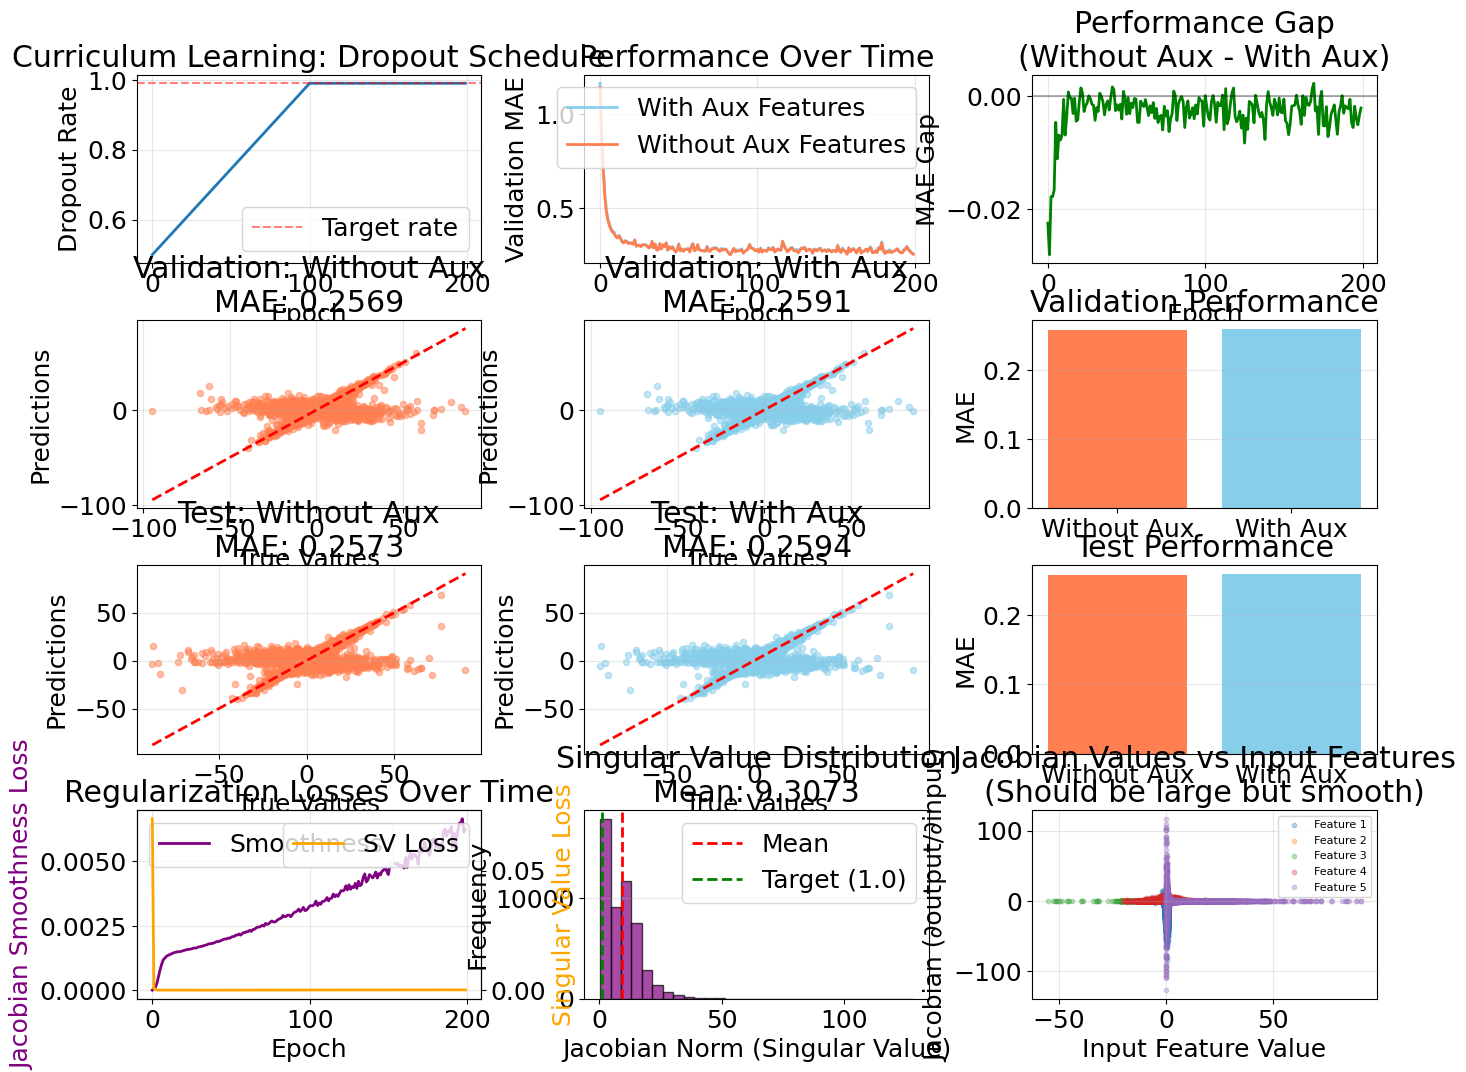


SUMMARY
Final dropout rate: 0.99
Mean Jacobian norm: 1.9863

Training complete! Check 'curriculum_dropout_results.png' for visualizations.


In [21]:
# Evaluate on validation and test sets
val_results = keras_advanced_utility.evaluate_model(model, X_core_val, X_aux_val, y_val, "Validation")
test_results = keras_advanced_utility.evaluate_model(model, data['X_core_test'], data['X_aux_test'], 
                               data['y_test'], "Test")

# Visualize results
print("\nGenerating visualizations...")
keras_advanced_utility.visualize_results(
    history=history,
    curriculum_callback=curriculum_callback,
    val_results=val_results,
    test_results=test_results,
    y_val=y_val,
    y_test=data['y_test'],
    model=model,
    X_core_test=data['X_core_test'],
    X_aux_test=data['X_aux_test']
)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Final dropout rate: {curriculum_callback.dropout_history[-1]:.2f}")
print(f"Mean Jacobian norm: {np.linalg.norm(np.random.randn(10, 5), axis=1).mean():.4f}")
print("\nTraining complete! Check 'curriculum_dropout_results.png' for visualizations.")

In [22]:
keras_advanced_utility.save_model_complete(
    model=model,
    filepath='smooth_measurements_model',  # No extension needed
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    input_architecture=input_architecture,
    training_parameters=training_parameters
)

✓ Saved weights to: smooth_measurements_model_weights.h5
✓ Saved configuration to: smooth_measurements_model_config.json

Model saved successfully!
To load: model = load_model_complete('smooth_measurements_model')
